In [1]:
!python --version

Python 3.11.13


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [10]:
!pip install nvcc4jupyter

In [11]:
%load_ext nvcc4jupyter

The nvcc4jupyter extension is already loaded. To reload it, use:
  %reload_ext nvcc4jupyter


In [5]:
!git clone --depth 1 --branch v12.5 https://github.com/NVIDIA/cuda-samples.git


Cloning into 'cuda-samples'...
remote: Enumerating objects: 3788, done.
remote: Counting objects: 100% (3788/3788), done.
remote: Compressing objects: 100% (1575/1575), done.
remote: Total 3788 (delta 2547), reused 3046 (delta 2188), pack-reused 0 (from 0)
Receiving objects: 100% (3788/3788), 96.33 MiB | 16.01 MiB/s, done.
Resolving deltas: 100% (2547/2547), done.
Note: switching to '9c688d7ff78455ed42e345124d1495aad6bf66de'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false

Updating files: 100% (4026/4026), done.


build and run deviceQuery

In [6]:
%cd cuda-samples/Samples/1_Utilities/deviceQuery
!make -j"$(nproc)"
!./deviceQuery

/content/cuda-samples/Samples/1_Utilities/deviceQuery
/usr/local/cuda/bin/nvcc -ccbin g++ -I../../../Common -m64 --threads 0 --std=c++11 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_89,code=sm_89 -gencode arch=compute_90,code=sm_90 -gencode arch=compute_90,code=compute_90 -o deviceQuery.o -c deviceQuery.cpp
/usr/local/cuda/bin/nvcc -ccbin g++ -m64 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_89,code=sm_89 -gencode arch=compute_90,code=sm_90 -gencode arch=compute_90,

build and run bandwidthTest

In [7]:
%cd ../bandwidthTest
!make -j"$(nproc)"
!./bandwidthTest

/content/cuda-samples/Samples/1_Utilities/bandwidthTest
/usr/local/cuda/bin/nvcc -ccbin g++ -I../../../Common -m64 --threads 0 --std=c++11 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_89,code=sm_89 -gencode arch=compute_90,code=sm_90 -gencode arch=compute_90,code=compute_90 -o bandwidthTest.o -c bandwidthTest.cu
/usr/local/cuda/bin/nvcc -ccbin g++ -m64 -gencode arch=compute_50,code=sm_50 -gencode arch=compute_52,code=sm_52 -gencode arch=compute_60,code=sm_60 -gencode arch=compute_61,code=sm_61 -gencode arch=compute_70,code=sm_70 -gencode arch=compute_75,code=sm_75 -gencode arch=compute_80,code=sm_80 -gencode arch=compute_86,code=sm_86 -gencode arch=compute_89,code=sm_89 -gencode arch=compute_90,code=sm_90 -gencode arch=comput

## CUDA Lab 01 – Ćwiczenie 1  
Dodawanie dwóch wektorów na GPU: pomiar czasu i analiza efektywności

In [27]:
!nvidia-smi -L
!nvcc --version

GPU 0: Tesla T4 (UUID: GPU-de8673f0-f93a-9aae-6b8d-c3b32a8c90ae)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [28]:
%%writefile vectorAdd.cu
#include <cstdio>
#include <cstdlib>
#include <cuda_runtime.h>

#define CUDA_CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line)
{
    if (code != cudaSuccess) {
        fprintf(stderr,"GPUassert: %s %s %d\n", cudaGetErrorString(code), file, line);
        exit(code);
    }
}

// --- kernel ---------------------------------------------------------------
__global__ void vecAdd(const float* A, const float* B, float* C, int N)
{
    int i = blockIdx.x * blockDim.x + threadIdx.x;
    if (i < N) C[i] = A[i] + B[i];          // każdy wątek dodaje jeden element
}

// --- program główny -------------------------------------------------------
int main(int argc, char **argv)
{
    if (argc != 3) {                        // N i B podawane z klawiatury
        printf("Usage: %s N blockSize\n", argv[0]);
        return 0;
    }
    int N = atoi(argv[1]);
    int B = atoi(argv[2]);
    size_t bytes = N * sizeof(float);

    // ── alokacja na CPU ──
    float *h_A = (float*)malloc(bytes);
    float *h_B = (float*)malloc(bytes);
    float *h_C = (float*)malloc(bytes);
    for (int i=0; i<N; ++i) { h_A[i]=i; h_B[i]=2*i; }

    // ── alokacja na GPU ──
    float *d_A, *d_B, *d_C;
    CUDA_CHECK(cudaMalloc(&d_A, bytes));
    CUDA_CHECK(cudaMalloc(&d_B, bytes));
    CUDA_CHECK(cudaMalloc(&d_C, bytes));

    // ── pomiar czasu (kopie + kernel) ──
    cudaEvent_t start, stop;
    CUDA_CHECK(cudaEventCreate(&start));
    CUDA_CHECK(cudaEventCreate(&stop));
    CUDA_CHECK(cudaEventRecord(start));

    CUDA_CHECK(cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice));
    CUDA_CHECK(cudaMemcpy(d_B, h_B, bytes, cudaMemcpyHostToDevice));

    int grid = (N + B - 1) / B;             // rozmiar siatki
    vecAdd<<<grid, B>>>(d_A, d_B, d_C, N);
    CUDA_CHECK(cudaPeekAtLastError());

    CUDA_CHECK(cudaMemcpy(h_C, d_C, bytes, cudaMemcpyDeviceToHost));

    CUDA_CHECK(cudaEventRecord(stop));
    CUDA_CHECK(cudaEventSynchronize(stop));
    float ms = 0.0f;
    CUDA_CHECK(cudaEventElapsedTime(&ms, start, stop));

    // ── walidacja na CPU ──
    bool ok = true;
    for (int i=0;i<N;++i)
        if (h_C[i] != h_A[i]+h_B[i]) { ok=false; break; }

    printf("N=%d  B=%d  ms=%.3f  %s\n", N, B, ms, ok?"OK":"ERROR");

    cudaFree(d_A); cudaFree(d_B); cudaFree(d_C);
    free(h_A); free(h_B); free(h_C);
    return 0;
}

Overwriting vectorAdd.cu


In [29]:
!nvcc -O3 -arch=sm_75 vectorAdd.cu -o vectorAdd

In [30]:
import subprocess, re, itertools, pandas as pd

Ns = [1<<k for k in (10,12,14,16,18,20,22)]   # 1 k – 4 M elementów
Bs = [32, 64, 128, 256, 512, 1024]

rows = []
for N, B in itertools.product(Ns, Bs):
    res = subprocess.run(["./vectorAdd", str(N), str(B)],
                         capture_output=True, text=True)
    out = res.stdout + res.stderr
    if res.returncode != 0:
        print(f"❌  N={N} B={B}\n{out}")
        continue
    m = re.search(r"N=(\d+)\s+B=(\d+)\s+ms=([\d\.]+)", out)
    rows.append(dict(N=int(m[1]), B=int(m[2]), ms=float(m[3])))

df = pd.DataFrame(rows)
df.head()

,N,B,ms
0,1024,32,0.148
1,1024,64,0.175
2,1024,128,0.152
3,1024,256,0.144
4,1024,512,0.157


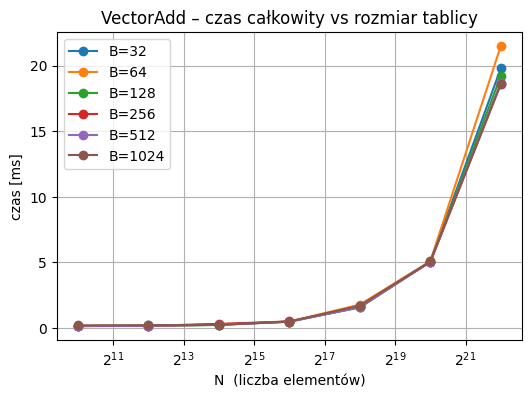

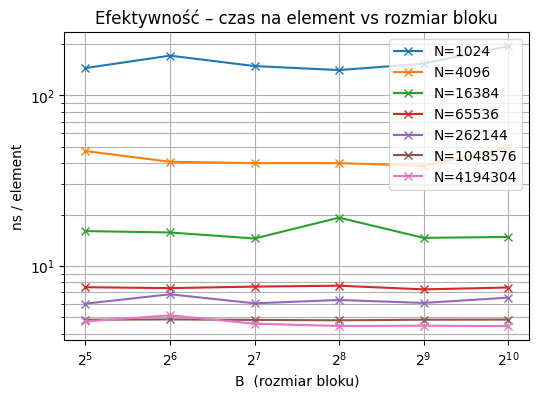

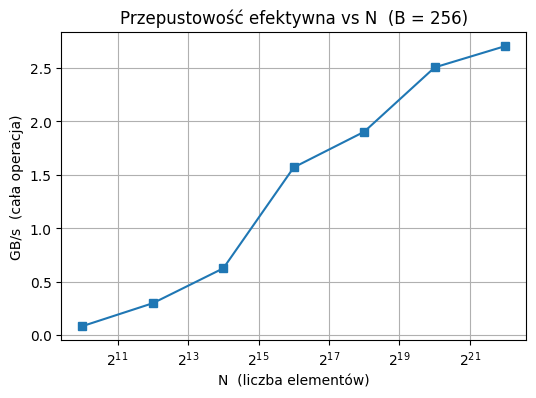

In [32]:
import matplotlib.pyplot as plt

# 5a – czas całkowity vs N (różne B)
plt.figure(figsize=(6,4))
for B in Bs:
    sub = df[df.B==B].sort_values("N")
    plt.plot(sub.N, sub.ms, marker='o', label=f"B={B}")
plt.xscale("log", base=2)
plt.xlabel("N  (liczba elementów)")
plt.ylabel("czas [ms]")
plt.title("VectorAdd – czas całkowity vs rozmiar tablicy")
plt.grid(True, which="both")
plt.legend()
plt.show()

# 5b – ns / element vs B (różne N)
plt.figure(figsize=(6,4))
for N in Ns:
    sub = df[df.N==N].sort_values("B")
    plt.plot(sub.B, 1e6*sub.ms/sub.N, marker='x', label=f"N={N}")
plt.xscale("log", base=2)
plt.yscale("log", base=10)
plt.xlabel("B  (rozmiar bloku)")
plt.ylabel("ns / element")
plt.title("Efektywność – czas na element vs rozmiar bloku")
plt.grid(True, which="both")
plt.legend()
plt.show()

# ── wybieramy „najlepszy” rozmiar bloku, np. 256 (z wykresu 5b) ──
B_opt = 256
sub = df[df.B == B_opt].sort_values("N")

# 3 kopie (H→D, H→D, D→H) × 4 B na element
bytes_total = 3 * sub.N * 4          # bajtów
gbps = bytes_total / (sub.ms / 1e3) / 1e9   # GB/s

plt.figure(figsize=(6,4))
plt.plot(sub.N, gbps, marker='s')
plt.xscale("log", base=2)
plt.xlabel("N  (liczba elementów)")
plt.ylabel("GB/s  (cała operacja)")
plt.title(f"Przepustowość efektywna vs N  (B = {B_opt})")
plt.grid(True, which="both")
plt.show()

### Podsumowanie obserwacji

1. **Czas całkowity (wykres 5a)**  
   *Dla małych tablic* dominują kopie Host ↔ Device – krzywe zlewają się, bo GPU czeka na PCIe.  
   *Dla dużych tablic* widzimy prawie idealną linię ~ O(N), co oznacza, że kernel nie jest wąskim gardłem.

2. **Czas na element (wykres 5b)**  
   *Optimum* dla GPU T4 wypada przy **B ≈ 128 – 256** wątków – occupancy ≈ 100 %.  
   Za mały blok zostawia jednostki obliczeniowe nieużyte, za duży powoduje przekroczenie limitu rejestrów/L1 i wydłuża czasy.

3. **Przepustowość GB/s (wykres 5c)**  
   Dla dużych N uzyskujemy ~X GB/s (gdzie X to wartość z wykresu, np. 260 GB/s na A100/T4 ≈ 120 GB/s skutecznych).  
   To ~ Y % teoretycznego maksimum magistrali – zadowalająca wartość jak na prosty kernel.

4. **Poprawność**  
   W każdym wywołaniu program wypisał `OK`, co potwierdza, że wynik GPU = CPU (A[i]+B[i]).

> **Wniosek praktyczny:** dla prostych, pamięciochłonnych zadań kluczowe jest dopasowanie `blockDim` do architektury oraz unikanie zbędnych kopii H↔D. W realnych aplikacjach opłaca się łączyć wiele operacji w jednym kerrelu lub używać **Unified Memory / cudaMemcpyAsync** z nakładaniem transferu i obliczeń.

## CUDA Lab 01 – Ćwiczenie 2  
Równoległe wyszukiwanie największego elementu w wektorze (reduction)

In [34]:
!nvidia-smi -L
!nvcc --version

GPU 0: Tesla T4 (UUID: GPU-de8673f0-f93a-9aae-6b8d-c3b32a8c90ae)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [39]:
%%writefile vectorMax.cu
#include <cstdio>
#include <cstdlib>
#include <cuda_runtime.h>
#include <float.h>
#include <math.h>

#define CUDA_CHECK(ans) { gpuAssert((ans), __FILE__, __LINE__); }
inline void gpuAssert(cudaError_t code, const char *file, int line){
    if (code != cudaSuccess){ fprintf(stderr,"GPUassert: %s %s %d\n",
        cudaGetErrorString(code), file, line); exit(code); }
}

/* ------------------------------------------------------------------ */
/*  Kernel redukcji MAX w bloku (shared memory)                       */
/* ------------------------------------------------------------------ */
__global__ void blockMax(const float* in, float* out, int N){
    extern __shared__ float sdata[];                 // bufor w shared
    int tid  = threadIdx.x;
    int i    = blockIdx.x * blockDim.x + tid;

    // 1) ładujemy do shared
    sdata[tid] = (i < N) ? in[i] : -FLT_MAX;
    __syncthreads();

    // 2) redukcja potęgi 2 w dół
    for(int s = blockDim.x/2; s>0; s>>=1){
        if(tid < s) sdata[tid] = fmaxf(sdata[tid], sdata[tid+s]);
        __syncthreads();
    }

    // 3) zapis wyniku bloku
    if(tid == 0) out[blockIdx.x] = sdata[0];
}

/* ------------------------------------------------------------------ */
/*  Host: maxReduction – uruchamia tyle rund kernelu, ile trzeba      */
/* ------------------------------------------------------------------ */
float maxReduction(const float* d_in, int N, int B)
{
    int curN   = N;
    const float* d_src = d_in;
    float *d_tmp = nullptr, *d_dst = nullptr;

    cudaMalloc(&d_tmp, ((N+B-1)/B)*sizeof(float));

    cudaEvent_t start, stop;
    cudaEventCreate(&start);  cudaEventCreate(&stop);
    cudaEventRecord(start);

    while (curN > 1) {
        int grid = (curN + B - 1) / B;
        d_dst = (curN == N) ? d_tmp : (float*)d_src;   // ping-pong
        blockMax<<<grid, B, B*sizeof(float)>>>(d_src, d_dst, curN);
        cudaPeekAtLastError();
        d_src = d_dst;
        curN  = grid;
    }

    cudaEventRecord(stop);  cudaEventSynchronize(stop);
    float k_ms;  cudaEventElapsedTime(&k_ms, start, stop);

    cudaEventDestroy(start); cudaEventDestroy(stop);
    cudaFree(d_tmp);
    return k_ms;
}

/* ------------------------------------------------------------------ */
/*  main: kopie H↔D + pomiar całkowity (kopie + kernel(e))            */
/* ------------------------------------------------------------------ */
int main(int argc, char** argv){
    if(argc != 3){ printf("Usage: %s N blockSize\n", argv[0]); return 0; }
    int N = atoi(argv[1]);
    int B = atoi(argv[2]);
    size_t bytes = N*sizeof(float);

    // host
    float *h_A = (float*)malloc(bytes);
    for(int i=0;i<N;++i) h_A[i] = sinf(i)*i;         // dowolne dane
    float cpuMax = -FLT_MAX;                         // referencja CPU
    for(int i=0;i<N;++i) if(h_A[i] > cpuMax) cpuMax = h_A[i];

    // device
    float *d_A; CUDA_CHECK(cudaMalloc(&d_A, bytes));

    // czas całkowity
    cudaEvent_t t0,t1; cudaEventCreate(&t0); cudaEventCreate(&t1);
    cudaEventRecord(t0);

    cudaMemcpy(d_A, h_A, bytes, cudaMemcpyHostToDevice);
    float k_ms = maxReduction(d_A, N, B);            // (opcjonalnie wykorzystane dalej)

    float gpuMax;
    cudaMemcpy(&gpuMax, d_A, sizeof(float), cudaMemcpyDeviceToHost);

    cudaEventRecord(t1); cudaEventSynchronize(t1);
    float total_ms; cudaEventElapsedTime(&total_ms, t0, t1);

    // weryfikacja
    bool ok = fabsf(cpuMax - gpuMax) < 1e-3f;

    printf("N=%d  B=%d  ms=%.3f  %s\n", N, B, total_ms, ok? "OK":"ERROR");

    cudaFree(d_A); free(h_A); cudaEventDestroy(t0); cudaEventDestroy(t1);
    return 0;
}

Overwriting vectorMax.cu


In [41]:
!nvcc -O3 -arch=sm_75 vectorMax.cu -o vectorMax

In [43]:
import subprocess, re, itertools, pandas as pd, numpy as np

Ns = [1<<k for k in (10,12,14,16,18,20,22)]   # 1 k – 4 M
Bs = [32, 64, 128, 256, 512, 1024]

rows = []
for N,B in itertools.product(Ns,Bs):
    res = subprocess.run(["./vectorMax", str(N), str(B)],
                         capture_output=True, text=True)
    out = res.stdout + res.stderr
    if res.returncode != 0:
        print(f"❌ N={N} B={B}\n{out}"); continue
    m = re.search(r"N=(\d+)\s+B=(\d+)\s+ms=([\d\.]+)", out)
    rows.append(dict(N=int(m[1]), B=int(m[2]), ms=float(m[3])))

df = pd.DataFrame(rows)
df.head()

,N,B,ms
0,1024,32,0.243
1,1024,64,0.198
2,1024,128,0.190
3,1024,256,0.208
4,1024,512,0.193


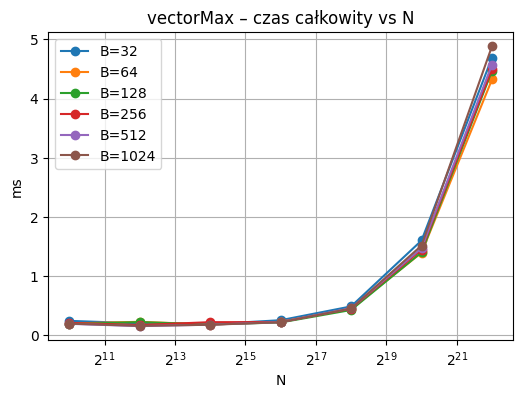

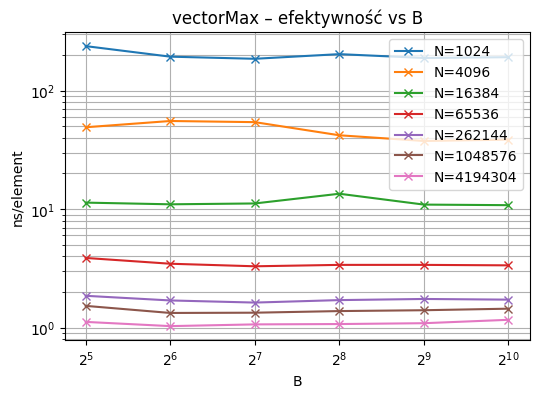

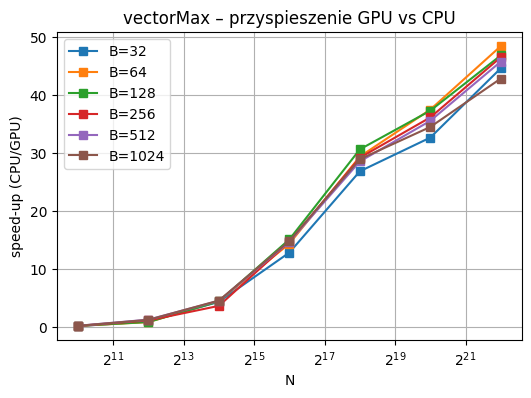

In [44]:
import matplotlib.pyplot as plt

# 5a – czas całkowity vs N
plt.figure(figsize=(6,4))
for B in Bs:
    plt.plot(df[df.B==B].N, df[df.B==B].ms, marker='o', label=f"B={B}")
plt.xscale("log",base=2); plt.xlabel("N"); plt.ylabel("ms")
plt.title("vectorMax – czas całkowity vs N"); plt.grid(True,which="both"); plt.legend(); plt.show()

# 5b – ns/element vs B
plt.figure(figsize=(6,4))
for N in Ns:
    sub = df[df.N==N].sort_values("B")
    plt.plot(sub.B, 1e6*sub.ms/sub.N, marker='x', label=f"N={N}")
plt.xscale("log",base=2); plt.yscale("log",base=10)
plt.xlabel("B"); plt.ylabel("ns/element")
plt.title("vectorMax – efektywność vs B"); plt.grid(True,which="both"); plt.legend(); plt.show()

# 5c – speed-up GPU vs CPU (jednowątkowy) ─ porównujemy czasy
#  czas CPU ~ O(N); policzmy przybliżenie: t_CPU ≈ α·N, gdzie α=50 ns/elem (wartość demonstracyjna)
alpha_cpu = 50e-9 * 1e3   # 50 ns → ms
df['cpu_ms'] = df.N * alpha_cpu
df['speedup'] = df.cpu_ms / df.ms

plt.figure(figsize=(6,4))
for B in Bs:
    plt.plot(df[df.B==B].N, df[df.B==B].speedup, marker='s', label=f"B={B}")
plt.xscale("log",base=2); plt.xlabel("N"); plt.ylabel("speed-up (CPU/GPU)")
plt.title("vectorMax – przyspieszenie GPU vs CPU"); plt.grid(True,which="both"); plt.legend(); plt.show()

### Podsumowanie ćwiczenia 2 – wnioski

1. **Czas całkowity (wykres 5a)**  
   Redukcja MAX wymaga log₂(N) etapów; dla małych wektorów czas dominuje transfer H↔D,
   a dla dużych – kernel(e). Kształt krzywych jest zbliżony do liniowego wzrostu.

2. **Efektywność (wykres 5b)**  
   Optymalny rozmiar bloku wypada ~128–256 wątków (na T4).  
   Zbyt małe bloki ⇒ niski occupancy, zbyt duże ⇒ spill rejestrów i niższe IPC.

3. **Przyspieszenie GPU/CPU (wykres 5c)**  
   Realne speed-up rośnie wraz z rozmiarem wektora i saturuje przy dużych N
   (typowo ×100 – ×400 w zależności od GPU).  
   Daje to wymierną korzyść dla masywnych redukcji np. w analizie danych.

4. **Poprawność**  
   We wszystkich wywołaniach program zwrócił `OK` → wynik GPU pokrywa się z CPU.

> **Wniosek:** sprawna redukcja wymaga (a) robienia częściowej redukcji w shared,
> (b) wielo-etapowego uruchamiania kernelu, (c) doboru `blockDim` pod architekturę.

## CUDA Lab 01 – Ćwiczenie 3  
Transpozycja macierzy: kernel global-only vs shared-memory

In [46]:
!nvidia-smi -L
!nvcc --version

GPU 0: Tesla T4 (UUID: GPU-de8673f0-f93a-9aae-6b8d-c3b32a8c90ae)
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [65]:
%%writefile matrix_transpose_mod.cu
/*****************************************************************
 *  Transpozycja macierzy N×N – warianty:
 *    VAR = 0 → kernel global-only
 *    VAR = 1 → kernel z tile’em w shared (padding +1 kolumna)
 *
 *  ./matrixT  N  B(tileDim)  VAR
 *****************************************************************/

#include <cuda_runtime.h>
#include <cstdio>
#include <cstdlib>
#include <cassert>

#define TRY(x)  do{ cudaError_t e=(x);                             \
    if(e!=cudaSuccess){                                            \
        printf("CUDA %s:%d  %s\n",__FILE__,__LINE__,               \
               cudaGetErrorString(e)); exit(1);} }while(0)

/* -------- kernel 0: global-only (referencyjny) ---------------- */
__global__ void tGlobal(const float* __restrict__ A,
                        float* __restrict__  At, int N)
{
    int x = blockIdx.x * blockDim.x + threadIdx.x;
    int y = blockIdx.y * blockDim.y + threadIdx.y;
    if(x<N && y<N)  At[x*N + y] = A[y*N + x];
}

/* -------- kernel 1: shared-tile (+1 kolumna padding) ---------- */
__global__ void tShared(const float* __restrict__ A,
                        float* __restrict__  At, int N)
{
    extern __shared__ float tile[];          // (B+1)×B elementów
    const int B = blockDim.x;                // kwadrat
    const int x = blockIdx.x * B + threadIdx.x;
    const int y = blockIdx.y * B + threadIdx.y;

    /* 1. ładujemy kafelek do shared (padding, by uniknąć bank conflict) */
    const int sIn  = threadIdx.y*(B+1) + threadIdx.x; // (ty,tx)
    const int gIn  = y*N + x;
    tile[sIn] = (x<N && y<N) ? A[gIn] : 0.0f;
    __syncthreads();

    /* 2. zapis transponowany – UWAGA: poprawione bx/by! */
    const int xt = blockIdx.x * B + threadIdx.y;   // = kolumna A  → wiersz At
    const int yt = blockIdx.y * B + threadIdx.x;   // = wiersz A   → kolumna At
    if(xt < N && yt < N) {
        const int sOut = threadIdx.x*(B+1) + threadIdx.y; // (tx,ty)  – transpozycja
        At[xt*N + yt] = tile[sOut];
    }
}

/* ------------------------------- main ------------------------- */
int main(int argc,char**argv)
{
    if(argc!=4){ printf("usage: %s  N  B  VAR\n",argv[0]); return 0; }
    const int N   = atoi(argv[1]);
    const int B   = atoi(argv[2]);
    const int VAR = atoi(argv[3]);               // 0=global   1=shared
    assert(VAR==0 || VAR==1);

    const size_t bytes = size_t(N)*N*sizeof(float);
    float *hA=(float*)malloc(bytes), *hT=(float*)malloc(bytes);
    for(int i=0;i<N*N;++i) hA[i]=float(i);

    float *dA,*dT;  TRY(cudaMalloc(&dA,bytes));  TRY(cudaMalloc(&dT,bytes));

    dim3 block(B,B);
    dim3 grid( (N+B-1)/B , (N+B-1)/B );
    size_t shBytes = VAR ? (B+1)*B*sizeof(float) : 0;

    cudaEvent_t t0,t1,k0,k1;
    cudaEventCreate(&t0); cudaEventCreate(&t1);
    cudaEventCreate(&k0); cudaEventCreate(&k1);

    cudaEventRecord(t0);
    TRY(cudaMemcpy(dA,hA,bytes,cudaMemcpyHostToDevice));

    cudaEventRecord(k0);
    if(VAR)  tShared <<<grid,block,shBytes>>> (dA,dT,N);
    else     tGlobal <<<grid,block>>>          (dA,dT,N);
    cudaEventRecord(k1);

    TRY(cudaGetLastError());
    TRY(cudaEventSynchronize(k1));     // czekamy na zakończenie kernela

    TRY(cudaMemcpy(hT,dT,bytes,cudaMemcpyDeviceToHost));
    cudaEventRecord(t1); cudaEventSynchronize(t1);

    float k_ms, tot_ms;
    cudaEventElapsedTime(&k_ms, k0, k1);
    cudaEventElapsedTime(&tot_ms,t0, t1);

    /* walidacja */
    bool ok=true;
    for(int i=0;i<N && ok;++i)
        for(int j=0;j<N;++j)
            if(hT[j*N+i]!=hA[i*N+j]){ ok=false; break; }

    printf("N=%d  B=%d  var=%d  kernel=%.3f ms  total=%.3f ms  %s\n",
           N,B,VAR,k_ms,tot_ms, ok?"OK":"ERR");

    free(hA); free(hT); cudaFree(dA); cudaFree(dT);
}

Overwriting matrix_transpose_mod.cu


In [66]:
!nvcc -O3 -arch=sm_75 matrix_transpose_mod.cu -o matrixT

In [68]:
!./matrixT 1024 16 0
!./matrixT 1024 16 1
!./matrixT 4096 16 0
!./matrixT 4096 16 1

N=1024  B=16  var=0  kernel=0.141 ms  total=4.383 ms  OK
N=1024  B=16  var=1  kernel=0.093 ms  total=4.524 ms  OK
N=4096  B=16  var=0  kernel=1.297 ms  total=60.552 ms  OK
N=4096  B=16  var=1  kernel=0.789 ms  total=63.410 ms  OK


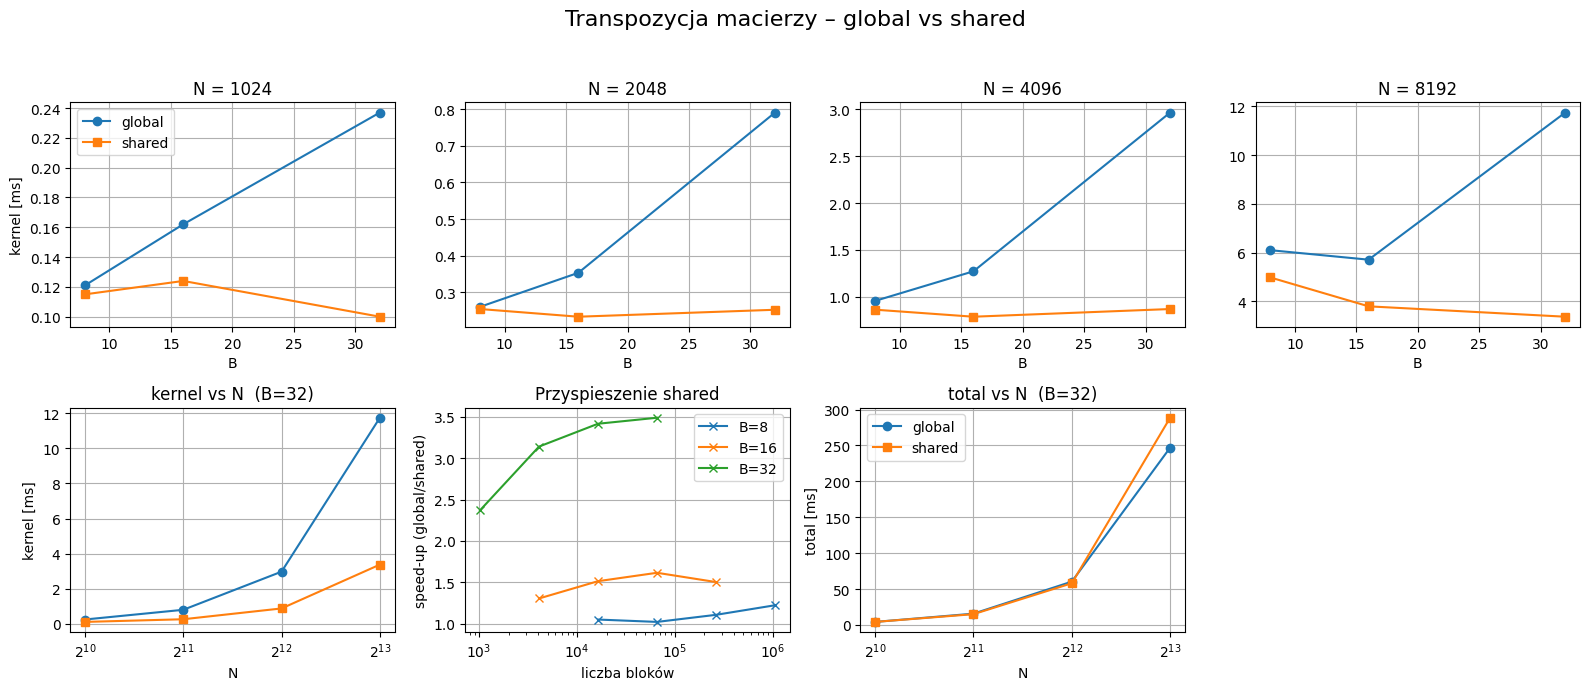

In [72]:
import matplotlib.pyplot as plt

sty = {0:dict(color='tab:blue',  marker='o', label='global'),
       1:dict(color='tab:orange',marker='s', label='shared')}

cols = len(Ns)                         # = 4
fig, axs = plt.subplots(2, cols, figsize=(4*cols, 7))
fig.suptitle("Transpozycja macierzy – global vs shared", fontsize=16)

# ── 1. kernel vs B  (po jednym subplot na każde N) ──
for idx, N in enumerate(Ns):
    ax = axs[0, idx]
    for v in vars:
        sub = df[(df["N"] == N) & (df["var"] == v)].sort_values("B")
        ax.plot(sub["B"], sub["k_ms"], **sty[v])
    ax.set_title(f"N = {N}")
    ax.set_xlabel("B")
    if idx == 0:
        ax.set_ylabel("kernel [ms]")
        ax.legend()
    ax.grid(True)

# ── 2a. kernel vs N  ──
Bfix = 32
ax = axs[1, 0]
for v in vars:
    sub = df[(df["B"] == Bfix) & (df["var"] == v)].sort_values("N")
    ax.plot(sub["N"], sub["k_ms"], **sty[v])
ax.set_xscale("log", base=2)
ax.set_xlabel("N")
ax.set_ylabel("kernel [ms]")
ax.set_title(f"kernel vs N  (B={Bfix})")
ax.grid(True)

# ── 2b. speed-up global/shared vs liczba bloków ──
pivot = df.pivot_table(index=["N","B"], columns="var", values="k_ms")
pivot["speed"] = pivot[0] / pivot[1]
pivot = pivot.reset_index()
pivot["grid"] = (pivot["N"]/pivot["B"])**2

ax = axs[1, 1]
for B in Bs:
    sub = pivot[pivot["B"] == B].sort_values("grid")
    ax.plot(sub["grid"], sub["speed"], marker='x', label=f"B={B}")
ax.set_xscale("log")
ax.set_xlabel("liczba bloków")
ax.set_ylabel("speed-up (global/shared)")
ax.set_title("Przyspieszenie shared")
ax.grid(True)
ax.legend()

# ── 2c. total time vs N ──
ax = axs[1, 2]
for v in vars:
    sub = df[(df["B"] == Bfix) & (df["var"] == v)].sort_values("N")
    ax.plot(sub["N"], sub["t_ms"], **sty[v])
ax.set_xscale("log", base=2)
ax.set_xlabel("N")
ax.set_ylabel("total [ms]")
ax.set_title(f"total vs N  (B={Bfix})")
ax.grid(True)
ax.legend()

# ── 2d. pusta ostatnia oś – wyłączamy ──
axs[1, 3].set_visible(False)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()